# Metropolis Monte Carlo for 2D Ising Model

$\textbf{2D Ising Model:}$Ising Model is one of the simple yet effective model which consists of a lattice with fixed number of sites. Each Lattice site has a spin with two degree of freedom (Si = ±1). Spins can either align themselves in upward direction(Si = +1) or in the downward(Si = +1) direction. The shape of the lattice here is s square . Thus, a two dimensional Ising Model with a size of L will consist of $L^2$ spins.

$\textbf{NOTE:}$ Use $\textit{Shift+Enter}$ to run the codes written in the cells.

## Need for Metropolis Algorithm
$\textit{Probabaility}$ of each microstate is given by:
$\begin{align}\tag{2.1}
P_c = \dfrac{e^{-\beta \hat{H}_i}}{\sum_ce^{-\beta \hat{H}_i}}
\end{align}$

To get the precise value of magnetization, we must calculate the magnetization for as many microstates/configurations as possible and then take the mean. Generating each and every microstate is a hopeless effort (For a small lattice size of L=10, number of possible microstates are $2^{100}$ ).
$\begin{align}\tag{1.1}
\langle M\rangle  = \dfrac{\sum_{c=1}^{2^{100}}m_c\times P_c}{2^{100}}
\end{align}$

But as in (1.1) the probability of every microstate is different. Without generating every single configuration, one can sample only those configurations which contribute most to the average (3.2). This is known as importance sampling. Here, the role of Metropolis Monte Carlo comes in. This importance sampling based algorithm reduces the computational time by a significant amount.

### Steps for 2D Ising simulation:

1.Create a configuration with random alignment of spins.

2.Randomly select a spin and flip it, to generate a trial configuration.

3.Compute the energy difference ($\Delta E = E_B-E_A$).

4.If $\Delta E<0$, accept the trial configuration with acceptance probability 1.

5.If $\Delta E>0$, accept the trial configuration with acceptance probability $e^{-\Delta E}$.

6.Perform sampling for large number of cycles.

## Code for equilibration
This function is called by the main file whenever necessary.

In [1]:
@everywhere function Equilibration(n_grid,T,J,L)

#creating random arrangement
grid=randn(n_grid,n_grid)
for i in 1:n_grid^2
    if grid[i]>0.5
        grid[i]=1
    else
        grid[i]=-1
    end
end

numIters = (2^9)*length(grid)

#pick a random spin
for iter in 1:numIters
    row = rand(1:n_grid)
    col = rand(1:n_grid)
    
    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]
    
    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors)
    
    #Spin flip condition
    if dE <= 0
        grid[row,col] = -grid[row,col]
    else
        prob=exp(-dE/T)
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col]
        end
    end
end
return grid
end

## Code for Calculating average properties (Production Run)
This function is called by the main file whenever necessary.

In [18]:
#Production
@everywhere function Production(n_grid,T,J,L,grid)
Mmean=zeros(1,L)
Emean=zeros(1,L)
for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)
    
    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]
    
    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors)
    
    #Spin flip condition
    if dE <= 0
        grid[row,col] = -grid[row,col]
    else
        prob=exp(-dE/T)
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col]
        end
    end
    
    #Calculating Properties
    Mmean[1,iter]=mean(grid)
    
    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
Ms=mean(Mmean);
#Es=mean(Emean)
xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr, Ms, xs
end

## Code for generating equilibrated arrangements by calling Equilibration
This function generates equilibrated arrangement for different temperatures.
It is called by the main code whenever necessary.

In [17]:
@everywhere function ising_over_temp(n_grid,J,L,Tmin,Tinc,Tmax)
len = floor((Tmax-Tmin)/Tinc);
len=convert(Int64,len);
#allocating required memory
gridqm=Array{Array{Int8}}(1,len+1);
Ts=Array{Float64}(1,len+1);
i=1;

# The temperature loop
print("equilibration started!","\n");
print("Number of steps = ",(2^8)*n_grid^2,"\n");
for T in Tmin:Tinc:Tmax
    grid = Equilibration(n_grid, T, J, L);

    #storing equilibrated arrangements with temperature 
    gridqm[1,i] = grid;
    Ts[1,i] = T;
    i=i+1;
end
print("equilibration finished!","\n");
len = length(Ts);
return gridqm, Ts, len
end

In [21]:
@everywhere function Ising(n_grid,L,J,P,Tmin,Tinc,Tmax)
gridqm, Ts, len = ising_over_temp(n_grid,J,L,Tmin,Tinc,Tmax)

Mp=zeros(P,len);
x=zeros(P,len);

for Pr in 1:P
    print("production run = ",Pr,"\n")
    for h in 1:len
        gridpr,Ms,xs = Production(n_grid,Ts[1,h],J,L,gridqm[1,h])
        #print(h,"\n")
        Mp[Pr,h] = Ms;
        x[Pr,h] = xs;
    end
end

Mp_avg=mean(Mp,1);
x_avg=mean(x,1);
Ts



#using Plots
#plt1 = Plots.scatter(Ts,Mp_avg,color="red",legend=false,xaxis="Temp",yaxis="<M>/spin");
#plt2 = Plots.scatter(Ts,x_avg,color="green", reuse= false,legend=false,xaxis="Temp",yaxis="<x>/spin");
#display(plt1)
#display(plt2)

    #using Gadfly
    #plt1=plot(x=Ts,y=Mp_avg,Guide.xlabel("Temp"),Guide.ylabel("Magnetisation/site"))
    #plt2=plot(x=Ts,y=x_avg,Guide.xlabel("Temp"),Guide.ylabel("Susceptibility/site"))
    #display(plt1)
    #display(plt2)

    print("FINISHED!")
    return Mp_avg, x_avg, Ts
end

## Main Code with input parameters
$\textbf{NOTE:}$Run all the codes in above cells before running this main code as it uses functions which are defined above.

This is the main code that calculates magnetisation and susceptibility.

Change the input parameters within next cell and press $\textit{Shift+Enter}$ to run the simulation.

$\textbf{Parameters ==>>}$ Ising(Lattice Size, MC steps, J, No. of Production Run, Tmin, Tinc, Tmax)

equilibration started!
Number of steps = 640000
equilibration finished!
production run = 1
production run = 2
FINISHED!

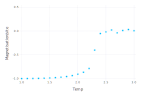

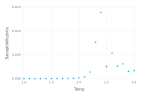

 36.887904 seconds (60.64 M allocations: 6.361 GiB, 7.20% gc time)


In [25]:
@time Ising(50,1000000,1,2,1,0.1,3)
using Gadfly
plt1=plot(x=Ts,y=Mp_avg,Guide.xlabel("Temp"),Guide.ylabel("Magnetisation/site"))
plt2=plot(x=Ts,y=x_avg,Guide.xlabel("Temp"),Guide.ylabel("Susceptibility/site"))
display(plt1)
display(plt2)

## Now using Parallel Programing

addprocs will allow this Jupyter notebook to use all the workers (CPUs) in this machine. I have 4 cores including hyperthreading. So,

In [9]:
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

$\textit{@spawn}$ is the syntax for distributing the jobs to the cores in a for loop. At the end, we divide by the number of cores to get the average estimate of properties among the cores.
Total MC steps will be diving within 4 cores.

In [23]:
function parallel_Ising(n_grid,L,J,P,Tmin,Tinc,Tmax,ncores::Int=4)

    #Compute properties in parallel, over ncores cores, with a Monte Carlo simulation 
    #Dividing MC steps over all available cores in parallel
    a=@spawn Ising(n_grid,ceil(Int, L / ncores),J,P,Tmin,Tinc,Tmax)
    b=@spawn Ising(n_grid,ceil(Int, L / ncores),J,P,Tmin,Tinc,Tmax)
    c=@spawn Ising(n_grid,ceil(Int, L / ncores),J,P,Tmin,Tinc,Tmax)
    d=@spawn Ising(n_grid,ceil(Int, L / ncores),J,P,Tmin,Tinc,Tmax)
    Mp1,x1,T1 = fetch(a)
    Mp2,x2,T2 = fetch(b)
    Mp3,x3,T3 = fetch(c)
    Mp4,x4,T4 = fetch(d)
    
     Mp_avg=(Mp1+Mp2+Mp3+Mp4)/ncores
    x_avg=(x1+x2+x3+x4)/ncores
    Ts=(T1+T2+T3+T4)/ncores
    return Mp_avg, x_avg, Ts  # average value
end

parallel_Ising (generic function with 2 methods)

This is the main code that calculates magnetisation and susceptibility by using all the CPU.

Change the input parameters within next cell and press $\textit{Shift+Enter}$ to run the simulation.

$\textbf{Parameters ==>>}$ parallel_Ising(Lattice Size, MC steps, J, No. of Production Run, Tmin, Tinc, Tmax)

	From worker 3:	FINISHED!equilibration started!
	From worker 3:	Number of steps = 640000
	From worker 4:	FINISHED!equilibration started!
	From worker 4:	Number of steps = 640000
	From worker 2:	FINISHED!equilibration started!
	From worker 2:	Number of steps = 640000
	From worker 5:	FINISHED!equilibration started!
	From worker 5:	Number of steps = 640000
	From worker 5:	equilibration finished!
	From worker 5:	production run = 1
	From worker 4:	equilibration finished!
	From worker 4:	production run = 1
	From worker 2:	equilibration finished!
	From worker 2:	production run = 1
	From worker 3:	equilibration finished!
	From worker 3:	production run = 1
	From worker 5:	production run = 2
	From worker 4:	production run = 2
	From worker 2:	production run = 2
	From worker 3:	production run = 2


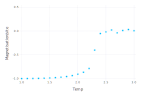

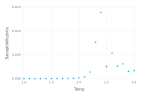

 22.071777 seconds (9.24 k allocations: 478.359 KiB)


In [26]:
@time parallel_Ising(50,1000000,1,2,1,0.1,3)
using Gadfly
plt1=plot(x=Ts,y=Mp_avg,Guide.xlabel("Temp"),Guide.ylabel("Magnetisation/site"))
plt2=plot(x=Ts,y=x_avg,Guide.xlabel("Temp"),Guide.ylabel("Susceptibility/site"))
display(plt1)
display(plt2)

In [70]:
@everywhere function m_hist_mc(n_grid,T,J,L,grid)
    m_hist = -(n_grid^2):2:(n_grid^2) ; m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; e_hist = collect(e_hist)
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ; e_hist = [ e_hist zeros(length(e_hist),1) ]

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; Enew = Eold + dE;

    #Spin flip condition
    if dE <= 0
        grid[row,col] = -grid[row,col] ; Eold = Enew ; Mnew = sum(grid) ; Mold = Mnew ;
    else
        prob=exp(-dE/T)
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col] ; Eold = Enew ;
            Mnew = sum(grid) ; Mold = Mnew ;
        end
    end

    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist
end


In [71]:
# grid = Equilibration(n_grid, T, J, L);
grid = Equilibration(8,2.5,1,100000)
# function m_hist_mc(n_grid,T,J,L,grid)


8×8 Array{Float64,2}:
  1.0  -1.0   1.0   1.0   1.0  -1.0  1.0  1.0
  1.0   1.0  -1.0   1.0   1.0  -1.0  1.0  1.0
  1.0   1.0   1.0   1.0  -1.0   1.0  1.0  1.0
  1.0  -1.0  -1.0  -1.0  -1.0   1.0  1.0  1.0
  1.0   1.0   1.0   1.0   1.0   1.0  1.0  1.0
 -1.0   1.0   1.0   1.0   1.0   1.0  1.0  1.0
  1.0   1.0   1.0   1.0   1.0   1.0  1.0  1.0
  1.0  -1.0   1.0   1.0   1.0   1.0  1.0  1.0

In [73]:
@time gridpr, m_hist, e_hist = m_hist_mc(8,2.5,1,10000000,grid)

  1.560425 seconds (7.98 M allocations: 730.420 MiB, 4.44% gc time)


([1.0 1.0 … 1.0 -1.0; 1.0 -1.0 … 1.0 1.0; … ; 1.0 1.0 … -1.0 1.0; 1.0 -1.0 … 1.0 1.0], [-64.0 47639.0; -62.0 116254.0; … ; 62.0 111699.0; 64.0 42196.0], [-128.0 89835.0; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0])

In [67]:
m_hist 

e_hist

65×2 Array{Float64,2}:
 -128.0   89912.0
 -124.0       0.0
 -120.0  229080.0
 -116.0   95886.0
 -112.0  348487.0
 -108.0  265787.0
 -104.0  440697.0
 -100.0  435717.0
  -96.0  529768.0
  -92.0  548032.0
  -88.0  599393.0
  -84.0  621057.0
  -80.0  652016.0
    ⋮            
   84.0       0.0
   88.0       0.0
   92.0       0.0
   96.0       0.0
  100.0       0.0
  104.0       0.0
  108.0       0.0
  112.0       0.0
  116.0       0.0
  120.0       0.0
  124.0       0.0
  128.0       0.0

In [68]:
sum(e_hist[:,2])
#sum(e_hist[:,2])

1.0e7

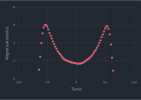

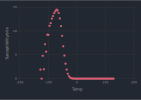

In [74]:
using Gadfly
plt1=plot(x=m_hist[:,1],y=m_hist[:,2]./m_hist[1,2],Guide.xlabel("Temp"),Guide.ylabel("Magnetisation/site"))
plt2=plot(x=e_hist[:,1],y=e_hist[:,2]./m_hist[1,2],Guide.xlabel("Temp"),Guide.ylabel("Susceptibility/site"))
display(plt1)
display(plt2)

In [176]:
@everywhere function Equilibration(n_grid,T,J,L)

#creating random arrangement
grid=randn(n_grid,n_grid)
for i in 1:n_grid^2
    if grid[i]>0.5
        grid[i]=1
    else
        grid[i]=-1
    end
end

numIters = (2^9)*length(grid)

#pick a random spin
for iter in 1:numIters
    row = rand(1:n_grid)
    col = rand(1:n_grid)
    
    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]
    
    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors)
    
    #Spin flip condition
    if dE <= 0
        grid[row,col] = -grid[row,col]
    else
        prob=exp(-dE/T)
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col]
        end
    end
end
return grid
end

In [177]:
@everywhere function m_tmmc(n_grid,T,J,L,grid)
    m_hist = -(n_grid^2):2:(n_grid^2) ; 
    m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; 
    e_hist = collect(e_hist)
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ;
    e_hist = [ e_hist zeros(length(e_hist),1) ] ;
    m_tm = [m_hist zeros(length(m_hist[:,1]),2)];
    m_tmn = copy(m_tm) ;
    

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; 
    Enew = Eold + dE; 
    prob=min(exp(-dE/T),1)
       
        
        if grid[row,col] < 0
            Mnew = Mold + 2 ;
        else
            Mnew = Mold - 2 ;
        end
        
        # transition matrix update
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_new_index = convert(Int64,((Mnew + n_grid^2)/2) + 1) ;
        e_new_index = convert(Int64,((Enew + 2*(n_grid^2)))/4 + 1) ;
        
        
        m_tm[m_old_index,2] += 1 ;
        if grid[row,col] < 0
          m_tm[m_old_index,3] += prob ;
       else
            m_tm[m_old_index,4] += prob ;
        end
        
        

    #Spin flip condition
   # if dE <= 0
      #  grid[row,col] = -grid[row,col] ; 
          #  Eold = Enew ; 
           # Mnew = sum(grid) ; 
          #  Mold = Mnew ;
   # else
        
        r=rand(1)
        if  r[1,1] <= prob
            grid[row,col] = -grid[row,col] ; 
            Eold = Enew ;
           # Mnew = sum(grid) ; 
            Mold = Mnew ;
        end
    #end

    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;
    


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist, m_tm
end


In [178]:
# grid = Equilibration(n_grid, T, J, L);
grid = Equilibration(8,1.5,1,100000)
# function m_hist_mc(n_grid,T,J,L,grid)


8×8 Array{Float64,2}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0

In [179]:
@time grid, m_hist, e_hist, m_tm = m_tmmc(8,1.5,1,1e7,grid)

  1.849247 seconds (10.03 M allocations: 916.878 MiB, 4.62% gc time)


([-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-64.0 6.96272e6; -62.0 2.17257e6; … ; 62.0 0.0; 64.0 0.0], [-128.0 6.96272e6; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0], [-64.0 6.96272e6 33615.7 0.0; -62.0 2.17257e6 19095.4 33580.0; … ; 62.0 0.0 0.0 0.0; 64.0 0.0 0.0 0.0])

In [180]:
m_hist

65×2 Array{Float64,2}:
 -64.0       6.96272e6
 -62.0       2.17257e6
 -60.0  609323.0      
 -58.0  168249.0      
 -56.0   53897.0      
 -54.0   19075.0      
 -52.0    7132.0      
 -50.0    3497.0      
 -48.0    1792.0      
 -46.0     782.0      
 -44.0     450.0      
 -42.0     163.0      
 -40.0     103.0      
   ⋮                  
  42.0       0.0      
  44.0       0.0      
  46.0       0.0      
  48.0       0.0      
  50.0       0.0      
  52.0       0.0      
  54.0       0.0      
  56.0       0.0      
  58.0       0.0      
  60.0       0.0      
  62.0       0.0      
  64.0       0.0      

In [181]:
e_hist

65×2 Array{Float64,2}:
 -128.0       6.96272e6
 -124.0       0.0      
 -120.0       2.17257e6
 -116.0  302378.0      
 -112.0  378429.0      
 -108.0   99513.0      
 -104.0   55132.0      
 -100.0   18159.0      
  -96.0    7397.0      
  -92.0    2589.0      
  -88.0     757.0      
  -84.0     232.0      
  -80.0      87.0      
    ⋮                  
   84.0       0.0      
   88.0       0.0      
   92.0       0.0      
   96.0       0.0      
  100.0       0.0      
  104.0       0.0      
  108.0       0.0      
  112.0       0.0      
  116.0       0.0      
  120.0       0.0      
  124.0       0.0      
  128.0       0.0      

In [182]:
m_tm

65×4 Array{Float64,2}:
 -64.0       6.96272e6  33615.7          0.0   
 -62.0       2.17257e6  19095.4      33580.0   
 -60.0  609323.0         7990.98     18959.0   
 -58.0  168249.0         3420.88      7960.0   
 -56.0   53897.0         1395.26      3376.92  
 -54.0   19075.0          604.468     1414.85  
 -52.0    7132.0          281.182      595.236 
 -50.0    3497.0          155.846      286.362 
 -48.0    1792.0           86.5184     158.106 
 -46.0     782.0           47.0644      89.85  
 -44.0     450.0           21.6459      47.2845
 -42.0     163.0            8.5673      17.6302
 -40.0     103.0            5.81831     10.3571
   ⋮                                           
  42.0       0.0            0.0          0.0   
  44.0       0.0            0.0          0.0   
  46.0       0.0            0.0          0.0   
  48.0       0.0            0.0          0.0   
  50.0       0.0            0.0          0.0   
  52.0       0.0            0.0          0.0   
  54.0       0.0 

In [183]:
m_tmn = copy(m_tm);
m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
m_tm_hist = ones(length(m_tmn[:,1]))
m_tm_hist
for iter in 2:length(m_tmn[:,1])
    m_tm_hist[iter] = m_tmn[iter-1,3]./m_tmn[iter,4];
end
m_tm_hist = cumprod(m_tm_hist)

65-element Array{Float64,1}:
   1.0        
   0.31236    
   0.0882353  
   0.0244587  
   0.00793712 
   0.00277017 
   0.00105181 
   0.000506401
   0.000255791
   0.000107484
   6.15635e-5 
   2.73789e-5 
   1.43111e-5 
   ⋮          
 NaN          
 NaN          
 NaN          
 NaN          
 NaN          
 NaN          
 NaN          
 NaN          
 NaN          
 NaN          
 NaN          
 NaN          

In [184]:
sum(e_hist[:,2])

1.0e7

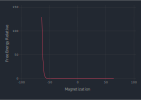

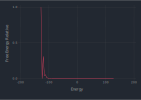

Stacktrace:
 [1] depwarn(::String, ::Symbol) at .\deprecated.jl:70
 [2] color(::String) at C:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\Colors\src\parse.jl:152
 [3] include_string(::String, ::String) at .\loading.jl:522
 [4] include_string(::Module, ::String, ::String) at C:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\Compat\src\Compat.jl:71
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\IJulia\src\execute_request.jl:158
 [6] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at C:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\Compat\src\Compat.jl:385
 [7] eventloop(::ZMQ.Socket) at C:\Users\Saraswati\AppData\Local\JuliaPro-0.6.2.2\pkgs-0.6.2.2\v0.6\IJulia\src\eventl

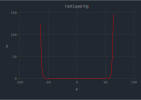

In [210]:
using Gadfly
plt1=plot(x=m_hist[:,1],y=m_hist[:,2]./m_hist[5,2],Geom.line,Guide.xlabel("Magnetization"),Guide.ylabel("Free Energy Relative"))
plt2=plot(x=e_hist[:,1],y=e_hist[:,2]./e_hist[1,2],Geom.line,Guide.xlabel("Energy"),Guide.ylabel("Free Energy Relative"))
display(plt1)
display(plt2)
plt3 = plot(#layer(x=m_hist[:,1],y=m_hist[:,2]./m_hist[5,2],Geom.line,Theme(default_color=color("green"))),
   # layer(x=m_hist[:,1],y=m_tm_hist./m_tm_hist[5],Geom.line,Theme(default_color=color("white"))),
   layer(x=m_hist[:,1],y=m_tm_hist_bm./m_tm_hist_bm[5],Geom.line,Theme(default_color=color("red"))),
    #layer(x=m_hist[:,1],y=m_hist_bm[:,2]./m_hist_bm[5,2],Geom.line,Theme(default_color=color("blue"))),
Guide.title("testLayering"))

In [169]:
m_tm_hist

65-element Array{Float64,1}:
 1.0       
 0.745062  
 0.415138  
 0.210845  
 0.10676   
 0.0561465 
 0.0308655 
 0.0181398 
 0.0110812 
 0.00725224
 0.00492004
 0.00329923
 0.00228181
 ⋮         
 0.0156629 
 0.0238295 
 0.0390833 
 0.0639447 
 0.104477  
 0.176935  
 0.310245  
 0.594371  
 1.17595   
 2.32763   
 4.0981    
 5.43109   

In [203]:
@everywhere function m_tmmc_biased(n_grid,T,J,L,grid,is_biased)
    m_hist = -(n_grid^2):2:(n_grid^2) ; 
    m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; 
    e_hist = collect(e_hist)
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ;
    e_hist = [ e_hist zeros(length(e_hist),1) ] ;
    m_tm = [m_hist zeros(length(m_hist[:,1]),2)];
    m_tmn = copy(m_tm) ;
    

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; 
    Enew = Eold + dE; 
    prob=min(exp(-dE/T),1)
       
        
        if grid[row,col] < 0
            Mnew = Mold + 2 ;
        else
            Mnew = Mold - 2 ;
        end
        
        # transition matrix update
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_new_index = convert(Int64,((Mnew + n_grid^2)/2) + 1) ;
        e_new_index = convert(Int64,((Enew + 2*(n_grid^2)))/4 + 1) ;
        
        
        m_tm[m_old_index,2] += 1 ;
        if grid[row,col] < 0
          m_tm[m_old_index,3] += prob ;
       else
            m_tm[m_old_index,4] += prob ;
        end
        
        
        #bias calculation
        bias = 1 ;
        if is_biased == true
        if iter > 1e6
        
            if grid[row,col] < 0 
                    if m_tm[m_old_index+1,4] !=0
                      bias = m_tmn[m_old_index+1,4]/m_tmn[m_old_index,3] ;
                    else 
                        bias = 1e10
                    end
            else
                    if m_tm[m_old_index-1 ,3] != 0
                        bias = m_tmn[m_old_index-1,3]/m_tmn[m_old_index,4] ;
                    else 
                        bias = 1e10 ;
                    end
            end
        end
        end

    #Spin flip condition
  
        biased_prob = bias * prob ;      
        r=rand(1)
        if  r[1,1] <= biased_prob
            grid[row,col] = -grid[row,col] ; 
            Eold = Enew ;
           # Mnew = sum(grid) ; 
            Mold = Mnew ;
        end


    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;
    
        if iter > 1e5 && mod(iter,1e5) == 0
            m_tmn = copy(m_tm);
            m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
            m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
        end


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist, m_tmn 
end


In [204]:
@time grid, m_hist_bm, e_hist_bm, m_tmn_bm = m_tmmc_biased(8,1.5,1,1e7,grid,true)

  2.376893 seconds (39.06 M allocations: 1.329 GiB, 6.20% gc time)


([-1.0 -1.0 … 1.0 1.0; 1.0 -1.0 … 1.0 1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … 1.0 -1.0], [-64.0 699887.0; -62.0 212999.0; … ; 62.0 423.0; 64.0 99348.0], [-128.0 799235.0; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0], [-64.0 699887.0 0.00482795 0.0; -62.0 212999.0 0.00880937 0.0159531; … ; 62.0 423.0 0.0141844 0.00827502; 64.0 99348.0 0.0 0.00482795])

In [205]:
#m_tmn = copy(m_tm);
#m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
#m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
m_tm_hist_bm = ones(length(m_tmn[:,1]))
m_tm_hist_bm
for iter in 2:length(m_tmn[:,1])
    m_tm_hist_bm[iter] = m_tmn_bm[iter-1,3]./m_tmn_bm[iter,4];
end
m_tm_hist_bm = cumprod(m_tm_hist_bm)

65-element Array{Float64,1}:
 1.0        
 0.302633   
 0.0861318  
 0.0253495  
 0.00806822 
 0.00319214 
 0.00141356 
 0.000671186
 0.000335199
 0.000180049
 9.84039e-5 
 5.79237e-5 
 3.54518e-5 
 ⋮          
 6.054e-5   
 0.000105752
 0.000183801
 0.000356895
 0.000715476
 0.00151598 
 0.00338819 
 0.00892994 
 0.0249239  
 0.0890581  
 0.401435   
 1.17941    

In [206]:
m_hist_bm

65×2 Array{Float64,2}:
 -64.0  699887.0
 -62.0  212999.0
 -60.0   60124.0
 -58.0   21873.0
 -56.0   13877.0
 -54.0   18152.0
 -52.0   26958.0
 -50.0   36691.0
 -48.0   49590.0
 -46.0   57672.0
 -44.0   72953.0
 -42.0   87308.0
 -40.0  101708.0
   ⋮            
  42.0   81376.0
  44.0   71134.0
  46.0   47487.0
  48.0   36234.0
  50.0   27662.0
  52.0   17275.0
  54.0   12756.0
  56.0    6237.0
  58.0    4820.0
  60.0    1126.0
  62.0     423.0
  64.0   99348.0

In [207]:
m_hist

65×2 Array{Float64,2}:
 -64.0       6.96272e6
 -62.0       2.17257e6
 -60.0  609323.0      
 -58.0  168249.0      
 -56.0   53897.0      
 -54.0   19075.0      
 -52.0    7132.0      
 -50.0    3497.0      
 -48.0    1792.0      
 -46.0     782.0      
 -44.0     450.0      
 -42.0     163.0      
 -40.0     103.0      
   ⋮                  
  42.0       0.0      
  44.0       0.0      
  46.0       0.0      
  48.0       0.0      
  50.0       0.0      
  52.0       0.0      
  54.0       0.0      
  56.0       0.0      
  58.0       0.0      
  60.0       0.0      
  62.0       0.0      
  64.0       0.0      

In [263]:
a = collect(1:10)
b = zeros(zeros(length(a),20))
c= broadcast(+,a,zeros(length(a),20))
#d = c[:]

10×20 Array{Float64,2}:
  1.0   1.0   1.0   1.0   1.0   1.0  …   1.0   1.0   1.0   1.0   1.0   1.0
  2.0   2.0   2.0   2.0   2.0   2.0      2.0   2.0   2.0   2.0   2.0   2.0
  3.0   3.0   3.0   3.0   3.0   3.0      3.0   3.0   3.0   3.0   3.0   3.0
  4.0   4.0   4.0   4.0   4.0   4.0      4.0   4.0   4.0   4.0   4.0   4.0
  5.0   5.0   5.0   5.0   5.0   5.0      5.0   5.0   5.0   5.0   5.0   5.0
  6.0   6.0   6.0   6.0   6.0   6.0  …   6.0   6.0   6.0   6.0   6.0   6.0
  7.0   7.0   7.0   7.0   7.0   7.0      7.0   7.0   7.0   7.0   7.0   7.0
  8.0   8.0   8.0   8.0   8.0   8.0      8.0   8.0   8.0   8.0   8.0   8.0
  9.0   9.0   9.0   9.0   9.0   9.0      9.0   9.0   9.0   9.0   9.0   9.0
 10.0  10.0  10.0  10.0  10.0  10.0     10.0  10.0  10.0  10.0  10.0  10.0

In [212]:
a

1-element Array{UnitRange{Int64},1}:
 1:10

In [288]:
@everywhere function MeshGrid(vector1,vector2)
matrix2 = broadcast(+,vector2,zeros(length(vector1),length(vector2)))
matrix1 = broadcast(+,vector1,zeros(length(vector2),length(vector1)))
    matrix2 = transpose(matrix2)
return matrix1, matrix2
end

In [299]:
@everywhere function m_hist_2D(n_grid,T,J,L,grid,is_biased)
    m_hist = -(n_grid^2):2:(n_grid^2) ; 
    m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; 
    e_hist = collect(e_hist);
    m_hist_grid,e_hist_grid = MeshGrid(transpose(m_hist),transpose(e_hist))
    dd_me_hist = [  m_hist_grid[:]  e_hist_grid[:] ] ;
    dd_me_hist = [dd_me_hist zeros(length(dd_me_hist[:,2]),1)] ;
    
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ;
    e_hist = [ e_hist zeros(length(e_hist),1) ] ;
    m_tm = [m_hist zeros(length(m_hist[:,1]),2)];
    m_tmn = copy(m_tm) ;
    

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; 
    Enew = Eold + dE; 
    prob=min(exp(-dE/T),1)
       
        
        if grid[row,col] < 0
            Mnew = Mold + 2 ;
        else
            Mnew = Mold - 2 ;
        end
        
        # transition matrix update
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_new_index = convert(Int64,((Mnew + n_grid^2)/2) + 1) ;
        e_new_index = convert(Int64,((Enew + 2*(n_grid^2)))/4 + 1) ;
        
        
        m_tm[m_old_index,2] += 1 ;
        if grid[row,col] < 0
          m_tm[m_old_index,3] += prob ;
       else
          m_tm[m_old_index,4] += prob ;
        end
        
        
        #bias calculation
        bias = 1 ;
        if is_biased == true
        if iter > 1e6
        
            if grid[row,col] < 0 
                    if m_tm[m_old_index+1,4] !=0
                      bias = m_tmn[m_old_index+1,4]/m_tmn[m_old_index,3] ;
                    else 
                        bias = 1e10
                    end
            else
                    if m_tm[m_old_index-1 ,3] != 0
                        bias = m_tmn[m_old_index-1,3]/m_tmn[m_old_index,4] ;
                    else 
                        bias = 1e10 ;
                    end
            end
        end
        end

    #Spin flip condition
  
        biased_prob = bias * prob ;      
        r=rand(1)
        if  r[1,1] <= biased_prob
            grid[row,col] = -grid[row,col] ; 
            Eold = Enew ;
           # Mnew = sum(grid) ; 
            Mold = Mnew ;
        end


    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;
        
        dd_me_index = (m_old_index - 1) * length(e_hist[:,1]) + e_old_index ;
        dd_me_hist[dd_me_index,3] += 1 ;
    
        if iter > 1e5 && mod(iter,1e5) == 0
            m_tmn = copy(m_tm);
            m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
            m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
        end


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist, m_tmn ,dd_me_hist
end


In [302]:
@time gridpr,m_hist,e_hist, m_tmn ,dd_me_hist = m_hist_2D(8,2.5,1,1e7,grid,false)

  9.570856 seconds (50.00 M allocations: 7.154 GiB, 19.52% gc time)


([1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 1.0; -1.0 1.0 … -1.0 -1.0], [-64.0 45297.0; -62.0 120227.0; … ; 62.0 114786.0; 64.0 44474.0], [-128.0 89771.0; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0], [-64.0 45297.0 0.0407622 0.0; -62.0 120227.0 0.0502265 0.0151048; … ; 62.0 114786.0 0.0156378 0.0500986; 64.0 44474.0 0.0 0.0407622], [-64.0 -128.0 45297.0; -64.0 -124.0 0.0; … ; 64.0 124.0 0.0; 64.0 128.0 0.0])

In [305]:
dd_me_hist


4225×3 Array{Float64,2}:
 -64.0  -128.0  45297.0
 -64.0  -124.0      0.0
 -64.0  -120.0      0.0
 -64.0  -116.0      0.0
 -64.0  -112.0      0.0
 -64.0  -108.0      0.0
 -64.0  -104.0      0.0
 -64.0  -100.0      0.0
 -64.0   -96.0      0.0
 -64.0   -92.0      0.0
 -64.0   -88.0      0.0
 -64.0   -84.0      0.0
 -64.0   -80.0      0.0
   ⋮                   
  64.0    84.0      0.0
  64.0    88.0      0.0
  64.0    92.0      0.0
  64.0    96.0      0.0
  64.0   100.0      0.0
  64.0   104.0      0.0
  64.0   108.0      0.0
  64.0   112.0      0.0
  64.0   116.0      0.0
  64.0   120.0      0.0
  64.0   124.0      0.0
  64.0   128.0      0.0

In [304]:
sum(dd_me_hist)

1.0e7

In [307]:
f = open("ddHistT_2.2.txt","w")


IOStream(<file ddHistT_2.2.txt>)

In [308]:
 writedlm(f, dd_me_hist)

In [309]:
close(f)

In [318]:
correlation = sum(dd_me_hist[:,1] .* dd_me_hist[:,2].* dd_me_hist[:,3])/sum(dd_me_hist[:,3]) - (sum(dd_me_hist[:,2] .* dd_me_hist[:,3]) * sum(dd_me_hist[:,1] .* dd_me_hist[:,3]))/sum(dd_me_hist[:,3])^2

6.981907187213437


### 2D Transition Matrix Structuring

$ E \rightarrow E + 4 $

$ E \rightarrow E -4 $

$ E \rightarrow E + 8 $

$ E \rightarrow E - 8 $

$ M \rightarrow M + 2 $


$ M \rightarrow M - 2 $

2.Randomly select a spin and flip it, to generate a trial configuration.

3.Compute the energy difference ($\Delta E = E_B-E_A$).

4.If $\Delta E<0$, accept the trial configuration with acceptance probability 1.

5.If $\Delta E>0$, accept the trial configuration with acceptance probability $e^{-\Delta E}$.

6.Perform sampling for large number of cycles.

In [335]:
@everywhere function m_tmmc_2D(n_grid,T,J,L,grid,is_biased)
    m_hist = -(n_grid^2):2:(n_grid^2) ; 
    m_hist = collect(m_hist) ;
    e_hist =  (-2*(n_grid^2)):4:(2*(n_grid^2)) ; 
    e_hist = collect(e_hist);
    m_hist_grid,e_hist_grid = MeshGrid(transpose(m_hist),transpose(e_hist))
    dd_me_hist = [  m_hist_grid[:]  e_hist_grid[:] ] ;
    dd_me_hist = [dd_me_hist zeros(length(dd_me_hist[:,2]),1)] ;
    dd_me_tm = [dd_me_hist zeros(length(dd_me_hist[:,2]),10)] ;
    
    
    m_hist = [m_hist  zeros(length(m_hist),1) ]  ;
    e_hist = [ e_hist zeros(length(e_hist),1) ] ;
    m_tm = [m_hist zeros(length(m_hist[:,1]),2)];
    m_tmn = copy(m_tm) ;
    

    sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])

    Em = - J*grid.*sumofneighbors
    Eold=0.5*sum(Em)

    Mold = sum(grid)


for iter in 1:L
    row = rand(1:n_grid)
    col = rand(1:n_grid)

    #nearest neighbors
    if col==1
        left=n_grid
    else
        left=col-1
    end
    if col==n_grid
        right=1
    else
        right=col+1
    end
    if row==1
        below=n_grid
    else
        below=row-1
    end
    if row==n_grid
        above=1
    else
        above=row+1
    end

    neighbors=grid[above,col]+grid[row,left]+grid[row,right]+grid[below,col]

    #Energy change after spin flip
    dE = 2*(J*grid[row,col]*neighbors) ; 
    Enew = Eold + dE; 
    prob=min(exp(-dE/T),1)
       
        
        if grid[row,col] < 0
            Mnew = Mold + 2 ; dM = 2
        else
            Mnew = Mold - 2 ; dM = -2
        end
        
        # transition matrix update
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_new_index = convert(Int64,((Mnew + n_grid^2)/2) + 1) ;
        e_new_index = convert(Int64,((Enew + 2*(n_grid^2)))/4 + 1) ;
         dd_me_index = (m_old_index - 1) * length(e_hist[:,1]) + e_old_index ;
        
        if dE == -8 && dM == -2 
                         dd_change_index = 4
        elseif dE == -8  && dM == 2
                          dd_change_index = 5
        elseif dE == -4  && dM == -2
                           dd_change_index = 6
        elseif dE == -4  && dM == 2 
                          dd_change_index = 7
        elseif dE == 0  && dM == -2 
                         dd_change_index = 8
        elseif dE == 0  && dM == 2
                           dd_change_index = 9
        elseif dE == 4  && dM == -2
                           dd_change_index = 10
        elseif dE == 4  && dM == 2
                            dd_change_index = 11
        elseif dE == 8  && dM == -2 
                            dd_change_index = 12
        elseif dE == 8  && dM == 2 
                            dd_change_index = 13
        end
        
        
        dd_me_tm[dd_me_index,3] += 1 ;
        dd_me_tm[dd_me_index,dd_change_index] += prob ;
        
        
        m_tm[m_old_index,2] += 1 ;
        if grid[row,col] < 0
          m_tm[m_old_index,3] += prob ;
       else
          m_tm[m_old_index,4] += prob ;
        end
        
        
        #bias calculation
        bias = 1 ;
        if is_biased == true
        if iter > 1e6
        
            if grid[row,col] < 0 
                    if m_tm[m_old_index+1,4] !=0
                      bias = m_tmn[m_old_index+1,4]/m_tmn[m_old_index,3] ;
                    else 
                        bias = 1e10
                    end
            else
                    if m_tm[m_old_index-1 ,3] != 0
                        bias = m_tmn[m_old_index-1,3]/m_tmn[m_old_index,4] ;
                    else 
                        bias = 1e10 ;
                    end
            end
        end
        end

    #Spin flip condition
  
        biased_prob = bias * prob ;      
        r=rand(1)
        if  r[1,1] <= biased_prob
            grid[row,col] = -grid[row,col] ; 
            Eold = Enew ;
           # Mnew = sum(grid) ; 
            Mold = Mnew ;
        end


    #Calculating Properties
   #m_hist[find(m_hist[:,1].== Mold) ,2] += 1 ;
    # e_hist[find(e_hist[:,1].==Eold),2] += 1 ;
        m_old_index = convert(Int64,((Mold + n_grid^2)/2) + 1) ;
        e_old_index = convert(Int64,((Eold + 2*(n_grid^2)))/4 + 1) ;
        m_hist[m_old_index ,2] += 1 ;
        e_hist[e_old_index,2] += 1 ;
        
        dd_me_index = (m_old_index - 1) * length(e_hist[:,1]) + e_old_index ;
        dd_me_hist[dd_me_index,3] += 1 ;
    
        if iter > 1e5 && mod(iter,1e5) == 0
            m_tmn = copy(m_tm);
            m_tmn[:,3] = m_tmn[:,3]./m_tmn[:,2];
            m_tmn[:,4] = m_tmn[:,4]./m_tmn[:,2] ;
        end


    #sumofneighbors=circshift(grid,[0 1])+circshift(grid,[0 -1])+circshift(grid,[1 0])+circshift(grid,[-1 0])
    #Em = - J*grid.*sumofneighbors
    #E=0.5*sum(Em)
    #Emean[1,iter]=E/length(grid)
end
gridpr=grid;
#Ms=mean(Mmean);
#Es=mean(Emean)
#xs=(mean(Mmean.^2)-mean(Mmean)^2)/T;
#Cs=(mean(Emean.^2)-mean(Emean)^2)/T^2
return gridpr,m_hist,e_hist, m_tmn ,dd_me_hist, dd_me_tm 
end


In [336]:
@time gridpr,m_hist,e_hist, m_tmn ,dd_me_hist,dd_me_tm = m_tmmc_2D(8,2.5,1,1e7,grid,false)

  4.971889 seconds (70.10 M allocations: 13.118 GiB, 18.63% gc time)


([1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0], [-64.0 46691.0; -62.0 121647.0; … ; 62.0 113094.0; 64.0 41853.0], [-128.0 88544.0; -124.0 0.0; … ; 124.0 0.0; 128.0 0.0], [-64.0 46691.0 0.0407622 0.0; -62.0 121647.0 0.0501818 0.0159149; … ; 62.0 113094.0 0.0155357 0.0503019; 64.0 41853.0 0.0 0.0407622], [-64.0 -128.0 46691.0; -64.0 -124.0 0.0; … ; 64.0 124.0 0.0; 64.0 128.0 0.0], [-64.0 -128.0 … 0.0 1903.23; -64.0 -124.0 … 0.0 0.0; … ; 64.0 124.0 … 0.0 0.0; 64.0 128.0 … 0.0 0.0])

In [337]:
dd_me_tm

4225×13 Array{Float64,2}:
 -64.0  -128.0  46691.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1903.23
 -64.0  -124.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0  -120.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0  -116.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0  -112.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0  -108.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0  -104.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0  -100.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0   -96.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0   -92.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0   -88.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0   -84.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0 
 -64.0   -80.0      0.0  0.0  0.0  0.0

In [338]:
dd_me_hist

4225×3 Array{Float64,2}:
 -64.0  -128.0  46691.0
 -64.0  -124.0      0.0
 -64.0  -120.0      0.0
 -64.0  -116.0      0.0
 -64.0  -112.0      0.0
 -64.0  -108.0      0.0
 -64.0  -104.0      0.0
 -64.0  -100.0      0.0
 -64.0   -96.0      0.0
 -64.0   -92.0      0.0
 -64.0   -88.0      0.0
 -64.0   -84.0      0.0
 -64.0   -80.0      0.0
   ⋮                   
  64.0    84.0      0.0
  64.0    88.0      0.0
  64.0    92.0      0.0
  64.0    96.0      0.0
  64.0   100.0      0.0
  64.0   104.0      0.0
  64.0   108.0      0.0
  64.0   112.0      0.0
  64.0   116.0      0.0
  64.0   120.0      0.0
  64.0   124.0      0.0
  64.0   128.0      0.0